In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import spearmanr,pearsonr

In [2]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
pd.options.display.max_columns = 150

In [208]:
train = pd.read_csv('training_set.csv',index_col='Id')
train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target,dependency,techowaste,rent-missing,elecother
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,10,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,4,0.0,0,0,0
ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,12,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,4,0.0,0,0,0
ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,11,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,4,0.0,0,0,0
ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,9,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,4,1.0,0,0,0
ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,11,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,4,1.0,0,0,0


In [6]:
group = train.groupby('Target',sort=True)['Target'].count()

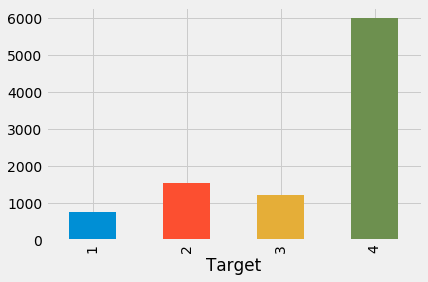

In [24]:
#lets see the number of samples present in the dataset for each poverty level
train.groupby('Target',sort=True)['Target'].count().plot(kind='bar')
plt.show()

#### we have an imbalanced class problem where we have a high number of non-vulnerable households.
#### we can apply suitable methods such as oversampling to help our model with predicting these levels correctly.
#### we should be taking this into consideration in the modelling phase.

In [22]:
#for plotting distributions with respect to each poverty level
def plot_distribution_cat(data,column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
    poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})
    for i,col in enumerate(column_list):
        ax = plt.subplot(4,2,i+1)
        for level,color in colors.items():
            sns.kdeplot(train.loc[train['Target'] == level, col],ax=ax,color=color,label=poverty_mapping[level])
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
    plt.subplots_adjust(top = 2)

def plot_categorical(column,desc,label,kind):
    grouped = train.groupby(['Target'])[column].value_counts(normalize=True)
    grouped = grouped.rename('count')
    grouped = grouped.reset_index(['Target',column])
    if kind == 'bar':
        sns.barplot(x=column, y="count", hue="Target", data=grouped,palette=OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}))
        if isinstance(label[0],str):
            rotation=60
        else:
            rotation=0
    elif kind == 'point':
        sns.pointplot(x=column, y="count", hue="Target", data=grouped,palette=OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'}),dodge=0.18)
        rotation=0
    plt.xlabel(desc)
    plt.ylabel('normalized_count')
    locs,labels = plt.xticks()
    plt.xticks(locs,label,rotation=rotation)
    plt.legend(loc='best')
    plt.show()
    
def create_ordinal_columns(df,feat_dict):
    for col_name,col_list in feat_dict.items():
        df[col_name] = df[col_list].apply(lambda x:np.argmax(x),axis=1,raw=True)
        print('created ordinal column {}'.format(col_name))

def corr_heatmap(column_list,method='pearson'):
    plt.figure(figsize = (8, 10))
    corr = train[column_list].corr(method)
    sns.heatmap(corr,annot=True,cmap='binary_r')
    plt.show()
#calculate spearman and pearson correlation of columns with the Target column    
def calc_sp_pr(columns):
    scorr = []
    S_p_value = []
    pcorr = []
    P_p_value = []
    for col in columns:
        scorr.append(spearmanr(train[col],train['Target']).correlation)
        pcorr.append(pearsonr(train[col],train['Target'])[0])
        S_p_value.append(spearmanr(train[col],train['Target']).pvalue)
        P_p_value.append(pearsonr(train[col],train['Target'])[1])
    return pd.DataFrame({'spearman_r':scorr,'S_p_value':S_p_value,'pearson_r':pcorr,'P_p_value':P_p_value},index=columns).sort_values('spearman_r',ascending=False)

def boxplot_distribution(column_list):
    plt.figure(figsize = (20, 16))
    colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
    poverty_mapping = ['extreme','moderate','vulnerable','non-vulnerable']
    for i,col in enumerate(column_list):
        ax = plt.subplot(4,2,i+1)
        sns.boxplot(x='Target',y=col,data=train,ax=ax,palette=colors)
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
        locs,labels = plt.xticks()
        plt.xticks(locs,poverty_mapping)
    plt.subplots_adjust(top = 2)

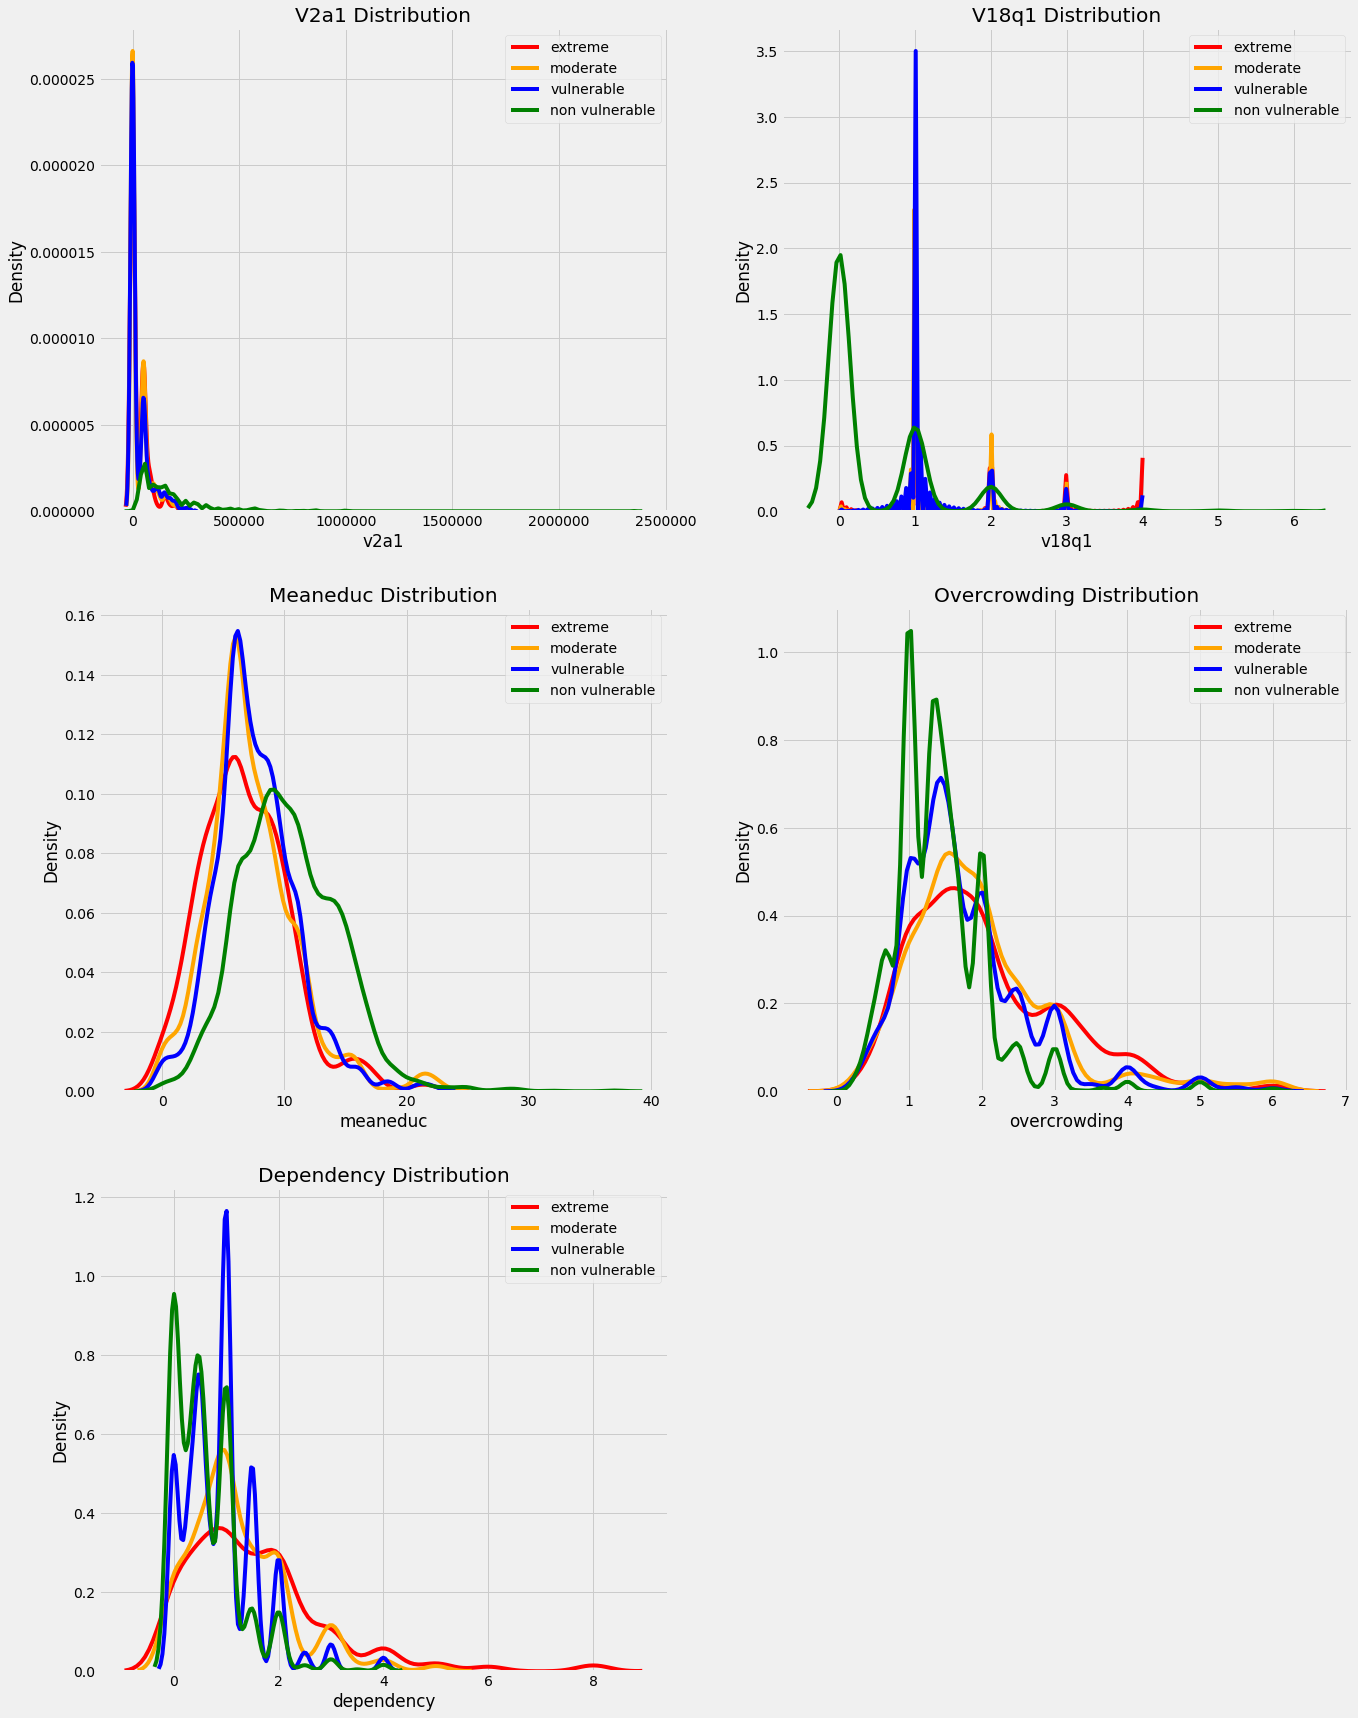

In [25]:
#let us check the distribution of our continuous value columns
float_columns = train.select_dtypes('float')
plot_distribution_cat(train,float_columns)

# a quick look at the figures allows to see if these columns have different distributions depending on the poverty level.

#### 1.we can see a clear difference in the v18q1 column,where vulnerable households usually own a single tablet,whereas non-vulnerable households have a range of values.We can also see a small spike for extreme households at 4,which is quite unexpected for the number of tablets owned.
#### 2.we can also see a difference in the overcrowding column where non-vulnerable households have spikes between 1 and 3 before its               distribution tapers off,whereas we see that much of the area of the distribution covers values from 1 to 4 before tapering off.
#### 3.we see that the non-vulnerable distribution in the meaneduc column is slightly shifted to the right than the other distributions,indicating a higher mean education for these households.

# Rooms

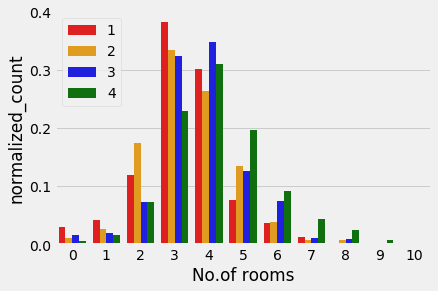

In [26]:
#let us check if there is a difference in the number of rooms in the households
plot_categorical('rooms','No.of rooms',kind='bar',label=[i for i in range(0,13)])

#### non-vulnerable households have a much larger range of rooms ranging from 0 to 11
#### the other households have 4-5 rooms and 6-7 in some cases

# r4t3, Total persons in the household, size of the household

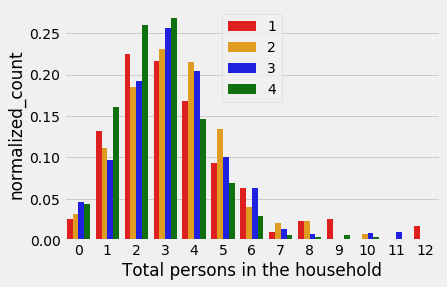

In [27]:
plot_categorical('hogar_total','Total persons in the household',label=[i for i in range(0,20)],kind='bar')

In [194]:
#let us check if there is a correlation between no.of rooms and total persons in the household
train[['rooms','r4t3']].corr()

,rooms,r4t3
rooms,1.00000,0.24583
r4t3,0.24583,1.00000


# No. of children,adults and elderly people

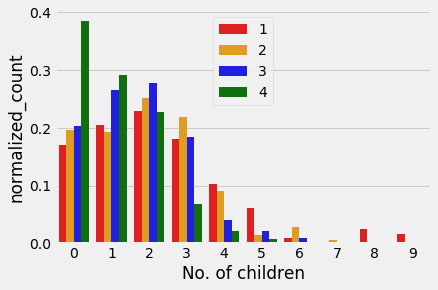

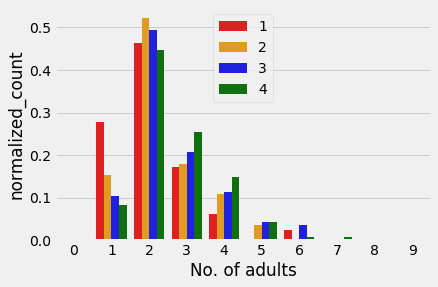

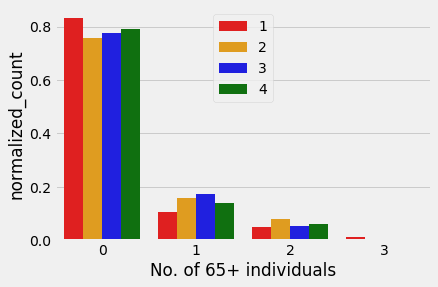

In [32]:
#let us check the no. of children,adults and elderly people for each poverty level.
plot_categorical('hogar_nin','No. of children',kind='bar',label=[i for i in range(0,15)])
plot_categorical('hogar_adul','No. of adults',kind='bar',label=[i for i in range(0,15)])
plot_categorical('hogar_mayor','No. of 65+ individuals',kind='bar',label=[i for i in range(0,15)])

#### There are more number of children in extreme and moderate poverty households compared to the other poverty levels,sometimes 8 or 9 in some cases.Vulnerable and non-vulnerable poverty level households have upto 3 children after which the counts taper off sharply from 4.

# Region

In [33]:
regions = [reg for reg in train.columns if reg.startswith('lugar')]
train['region'] = train[regions].apply(lambda x:np.argmax(x),axis=1,raw=True)
region_names=['Central','Chorotega','Pacafico central','Brunca','Huetar Atlantica','Huetar Norte']

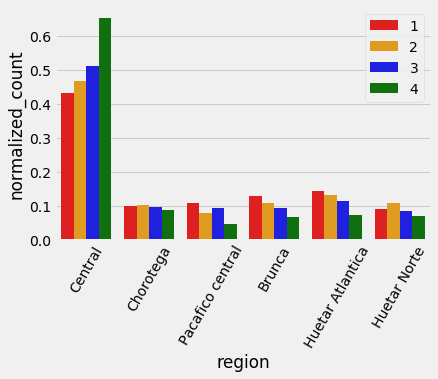

In [34]:
plot_categorical('region','region',region_names,kind='bar')

#### the poverty levels are more or less evenly distributed accross these regions.
#### There are a lot more samples from region 0 though.

# Education

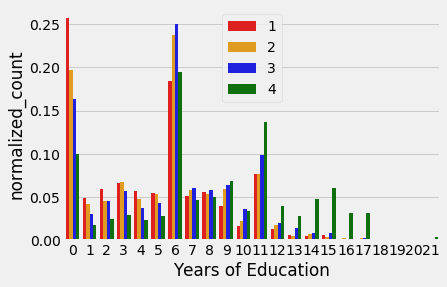

In [35]:
plot_categorical('escolari','Years of Education',label=[i for i in range(0,22)],kind='bar')

#### we observe three prominent spikes in the figure at year 0,6 and 11 for all the poverty levels.
####  we can also observe the fact that extreme poverty households have the highest count at year 0 followed by other poverty level households in descending order of the level.
#### only non vulnerable households appear to pursue higher education from year 12 onwards

# Amenities(Refrigerator,TV,bathroom,tablet,mobile phone,computer)

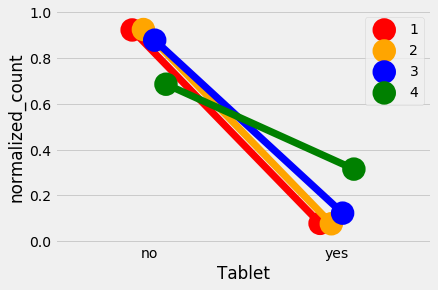

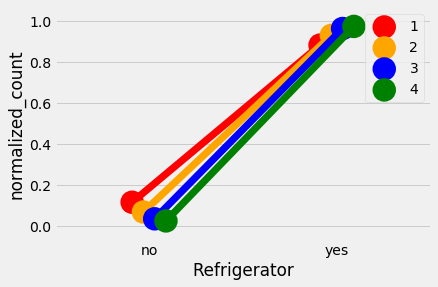

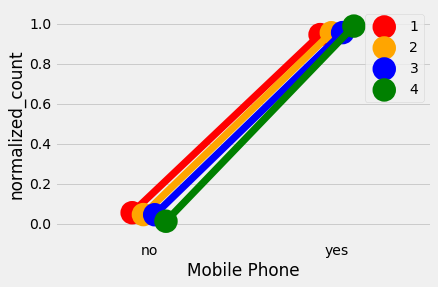

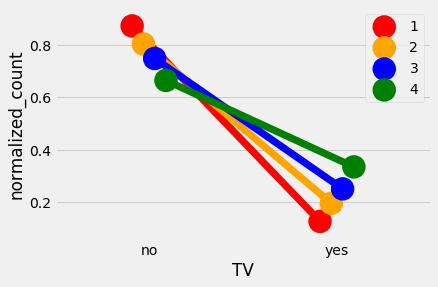

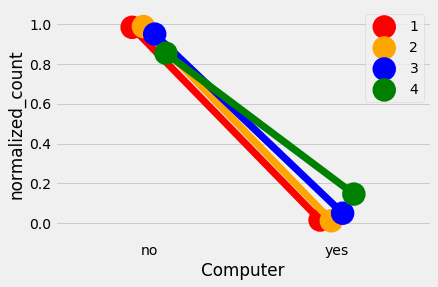

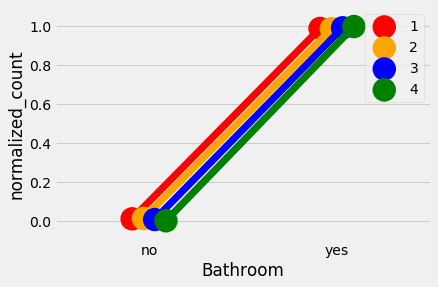

In [36]:
plot_categorical('v18q','Tablet',['no','yes'],kind='point')
plot_categorical('refrig','Refrigerator',['no','yes'],kind='point')
plot_categorical('mobilephone','Mobile Phone',['no','yes'],kind='point')
plot_categorical('television','TV',['no','yes'],kind='point')
plot_categorical('computer','Computer',['no','yes'],kind='point')
plot_categorical('v14a','Bathroom',['no','yes'],kind='point')

# Feature Construction
#### some columns have an inherent ordering between them,and therefore it would be useful if we incorporate this ordering or structure in our data
#### for e.g columns indicating wall quality have a natural ordering of bad < regular < good

In [210]:

ordinal_attributes = {'wall_attrib' :['paredother','pareddes','paredfibras','paredmad','paredzinc','paredzocalo','paredblolad','paredpreb'],
                       'floor_attrib':['pisonotiene','pisoother','pisonatur','pisomadera','pisocemento','pisomoscer'],
                       'roof_attrib' :['techootro','techowaste','techocane','techozinc','techoentrepiso'],
                       'water_attrib':['abastaguano','abastaguafuera','abastaguadentro'],
                       'electric_attrib' : ['noelec','elecother','coopele','public','planpri'],
                       'sanitary_attrib' : ['sanitario1','sanitario6','sanitario5','sanitario2','sanitario3'],
                       'energy_attrib' : ['energcocinar1','energcocinar4','energcocinar3','energcocinar2'],
                       'wall_qual' : ['epared1','epared2','epared3'],
                       'roof_qual' : ['etecho1','etecho2','etecho3'],
                       'floor_qual' : ['eviv1','eviv2','eviv3'],
                       'edu_level' : ['instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9'],
                       'ownership_status' : ['tipovivi5','tipovivi4','tipovivi3','tipovivi2','tipovivi1'],
                       'area':['area2','area1']
                  }

In [211]:
create_ordinal_columns(train,ordinal_attributes)

created ordinal column wall_attrib
created ordinal column floor_attrib
created ordinal column roof_attrib
created ordinal column water_attrib
created ordinal column electric_attrib
created ordinal column sanitary_attrib
created ordinal column energy_attrib
created ordinal column wall_qual
created ordinal column roof_qual
created ordinal column floor_qual
created ordinal column edu_level
created ordinal column ownership_status
created ordinal column area


In [212]:
# we need to drop the redundant attributes from the dataset
for col_list in ordinal_attributes.values():
    train.drop(col_list,axis=1,inplace=True)

In [314]:
#we need to drop one of the columns from [male,female] and [area1,area2] and rename them to gender and area
#female column dropped,male column renamed to gender indicating 1-->male,0-->female
#area2 dropped,area1 renamed to area indicating 1-->area1,0-->area2
train.drop('female',axis=1,inplace=True)
train = train.rename({'male':'gender','area1':'area'},axis='columns')

#### checking the correlation between household attributes

In [23]:
# household_level attributes
household_attributes = ['hacdor','rooms','hacapo','r4t3','tamviv','hhsize','hogar_total','bedrooms','overcrowding']
corr_heatmap(household_attributes)

NameError: name 'train' is not defined

<Figure size 576x720 with 0 Axes>

#### hhsize,r4t3 and hogar_total are prefectly correlated

In [48]:
#we can drop hhsize and r4t3 and keep hogar_total in our dataset
train.drop(['hhsize','r4t3'],axis=1,inplace=True)

# let us also check the correlation of all the variables with the target

In [49]:
house_attributes = ['wall_attrib','floor_attrib','roof_attrib','water_attrib','electric_attrib','sanitary_attrib','energy_attrib','wall_qual','roof_qual','floor_qual',\
'edu_level','ownership_status']
results = calc_sp_pr(house_attributes)
results

,spearman_r,S_p_value,pearson_r,P_p_value
floor_qual,0.311940,1.197532e-214,0.305525,1.476010e-205
edu_level,0.310980,2.836150e-213,0.303495,9.943568e-203
wall_qual,0.308101,3.505495e-209,0.306422,8.156755e-207
floor_attrib,0.290972,9.001166e-186,0.255359,4.344722e-142
roof_qual,0.274574,7.749612e-165,0.271237,9.462841e-161
energy_attrib,0.182561,2.194926e-72,0.196259,1.397722e-83
wall_attrib,0.086615,2.233943e-17,0.159407,2.087986e-55
water_attrib,0.075053,2.051500e-13,0.081693,1.270580e-15
roof_attrib,0.060744,2.814019e-09,0.054658,8.999381e-08
ownership_status,0.038569,1.626854e-04,0.085636,5.081852e-17


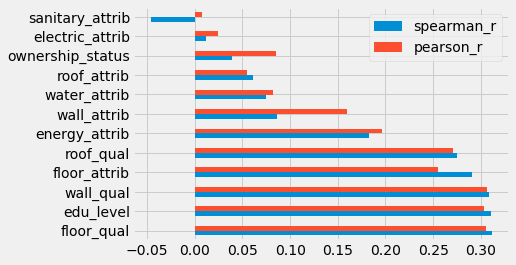

In [50]:
results[['spearman_r','pearson_r']].plot.barh()

#### floor,education level,wall,roof and floor quality have a slightly positive correlation with the poverty level
#### pearson and spearman correlation are in agreement for these attributes
#### these correlations have significant p-values as well.!!

In [51]:
# let us check the household attributes as well.
household_attributes = ['hacdor','rooms','hacapo','tamviv','hogar_total','bedrooms','overcrowding']
results = calc_sp_pr(household_attributes)
results

,spearman_r,S_p_value,pearson_r,P_p_value
rooms,0.233451,2.011468e-118,0.229098,5.296977e-114
bedrooms,0.172867,5.556657e-65,0.169324,2.209478e-62
hacapo,-0.134145,1.309332e-39,-0.137864,9.280434e-42
hogar_total,-0.149940,3.712787e-49,-0.145418,2.599999e-46
tamviv,-0.158251,1.271881e-54,-0.156569,1.719996e-53
hacdor,-0.181472,1.564292e-71,-0.192041,4.847154e-80
overcrowding,-0.281035,6.452714e-173,-0.290048,1.488547e-184


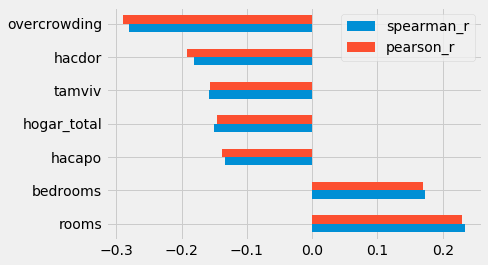

In [52]:
results[['spearman_r','pearson_r']].plot.barh()

#### overcrowding,hacdor,tamviv,hogar_total,hacapo have a negative correlation with poverty level.
#### This is understandable as these columns represent overcrowding,household size,persons living in each household etc.
#### We can see that as the poverty levels begin to decrease from non-vulnerable to extreme,these features begin to increase.
#### eg.extreme poverty levels tend to have more overcrowding whereas non-vulnerable households tend to have less overcrowding

In [53]:
amenities = ['v18q','refrig','mobilephone','television','computer','v14a']
results = calc_sp_pr(amenities)
results

,spearman_r,S_p_value,pearson_r,P_p_value
v18q,0.253768,2.740486e-140,0.239916,3.690668e-125
computer,0.192979,8.045035e-81,0.184188,1.140339e-73
television,0.155226,1.346371e-52,0.156882,1.062217e-53
refrig,0.119868,6.472114e-32,0.130310,1.864471e-37
mobilephone,0.109005,1.195764e-26,0.103676,2.996403e-24
v14a,0.065689,1.303187e-10,0.063316,5.857369e-10


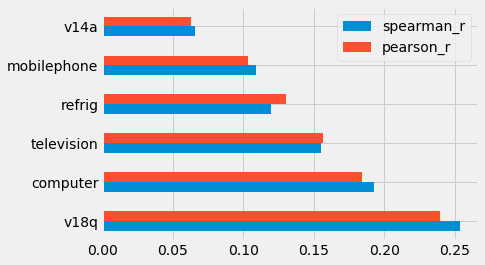

In [54]:
results[['spearman_r','pearson_r']].plot.barh()

#### amenities like refrigerator,television,mobile phone etc have a positive correlation with the poverty level.
#### as the poverty level increases from extreme to non-vulnerable,we tend to see an increase in the households/individuals holding these amenities
#### the correlations are somewhat weak ranging from 0.06-0.23

## feature engineering

In [ ]:
#![alt text](imagename.png "Title")--for pasting images

In [ ]:
#diff between persons living and size of the household
#a positive score for having amenities like refrigerator,TV etc
#a pos score for living in an urban area
#score for good house condition
#households with female heads,more number of young children and elderly,living in rural areas are indicators of poverty
#school age children not attending school
# standard of living feature to assess if households have amenities like refrigerator,TV and other assets etc
#mean age of head of household
#mean edu of household head
#mean of no. of children age 12 and under,individuals age 65+ and over,mean of children under 18

![alt text](poverty_rate.png "Poverty rate by region")

![alt text](characteristics.png "characteristics of households at different poverty levels")

### age of the head as a feature

In [215]:
#age of the head as a feature
idx_head = train[['idhogar','age']][train.parentesco1 == 1]

In [216]:
train['age_of_head'] = 0

In [217]:
for row in idx_head.itertuples():
    train['age_of_head'][train.idhogar == row.idhogar] = row.age

## if household head is female as a feature

In [218]:
#if household head is female as a feature
train['female_head'] = 0

In [219]:
train['female_head'][(train.parentesco1 == 1) & (train.female == 1)] = 1

## education of head of household

In [220]:
#education of head of household
idx_edu_head = train[['idhogar','escolari']][train.parentesco1 == 1]

In [221]:
train['edu_head'] = 0

In [222]:
for row in idx_edu_head.itertuples():
    train['edu_head'][train.idhogar == row.idhogar] = row.escolari

## proportion of children under 12

In [223]:
## proportion of children under 12
train['prop_under_12'] = train['r4t1']/train['hogar_total']

## proportion of adults

In [224]:
#proportion of adults
train['prop_adults'] = train['hogar_adul']/train['hogar_total']

## proportion of elderly

In [225]:
#proportion of elderly
train['prop_elderly'] = train['hogar_mayor']/train['hogar_total']

## education of children 0-12

In [226]:
#education of children 0-12
idx_edu_chld = train[train.age <= 12].groupby('idhogar')['escolari'].mean()
idx_edu_chld = idx_edu_chld.reset_index()

In [227]:
train['mean_edu_child'] = 0.0

In [228]:
for row in idx_edu_chld.itertuples():
    train['mean_edu_child'][train.idhogar == row.idhogar] = row.escolari

## education of children 12-18

In [229]:
#education of children 12-18
idx_edu_teen = train[(train.age >= 12) & ( train.age < 19)].groupby('idhogar')['escolari'].mean()
idx_edu_teen = idx_edu_teen.reset_index()

In [230]:
train['mean_edu_teen'] = 0.0

In [231]:
for row in idx_edu_teen.itertuples():
    train['mean_edu_teen'][train.idhogar == row.idhogar] = row.escolari

## standard of living score
1/4(1/4(electricity) + 1/2(water) + 1/3(energy) +  1/5(sanitation) + 1/6(refrig + TV + mobile + tablet + computer + bathroom))

In [97]:
#standard of living score
#it would consider electricity,water,energy used for cooking,sanitation,amenities like refrigerator,TV,mobile phone etc.
# it would have a low score 0 and a max score of 1
#since we have ordered these features,it would be easy for us to normalize and add them for a final score.

In [232]:
train['standard_of_living'] = 1/5 * (1/4 * train['electric_attrib'] + 1/2 * train['water_attrib'] + 1/3 * train['energy_attrib'] + 1/4 * train['sanitary_attrib']\
+ 1/5 * (train['refrig'] + train['television'] + train['v18q'] + train['mobilephone'] + train['computer']))

## house_quality
#### outside_wall + roof + floor + cieling
1/4(1/2(wall qual) x 1/6(wall_attrib) + 1/2(floor qual) x 1/5(floor_attrib) + 1/2(roof qual) x 1/4(roof_attrib) + ceiling)

In [233]:
train['house_quality'] = 1/4 * ((1/2 * train['wall_qual']) * (1/6 * train['wall_attrib']) + (1/2 * train['floor_qual']) * (1/6 * train['floor_attrib']) + (1/2 * train['roof_qual']) * (1/6 * train['roof_attrib']) + train['cielorazo'])

### safe waste disposal
#### if disposal by tanker truck or burying 

In [234]:
train['safe_waste_disposal'] = 0
train['safe_waste_disposal'][(train.elimbasu1 == 1) | (train.elimbasu2 == 1)] = 1

## let us examine the distribution and relationship with the target variable

In [169]:
cont_variables = ['prop_adults','prop_under_12','prop_elderly','mean_edu_child','mean_edu_teen','standard_of_living','house_quality']

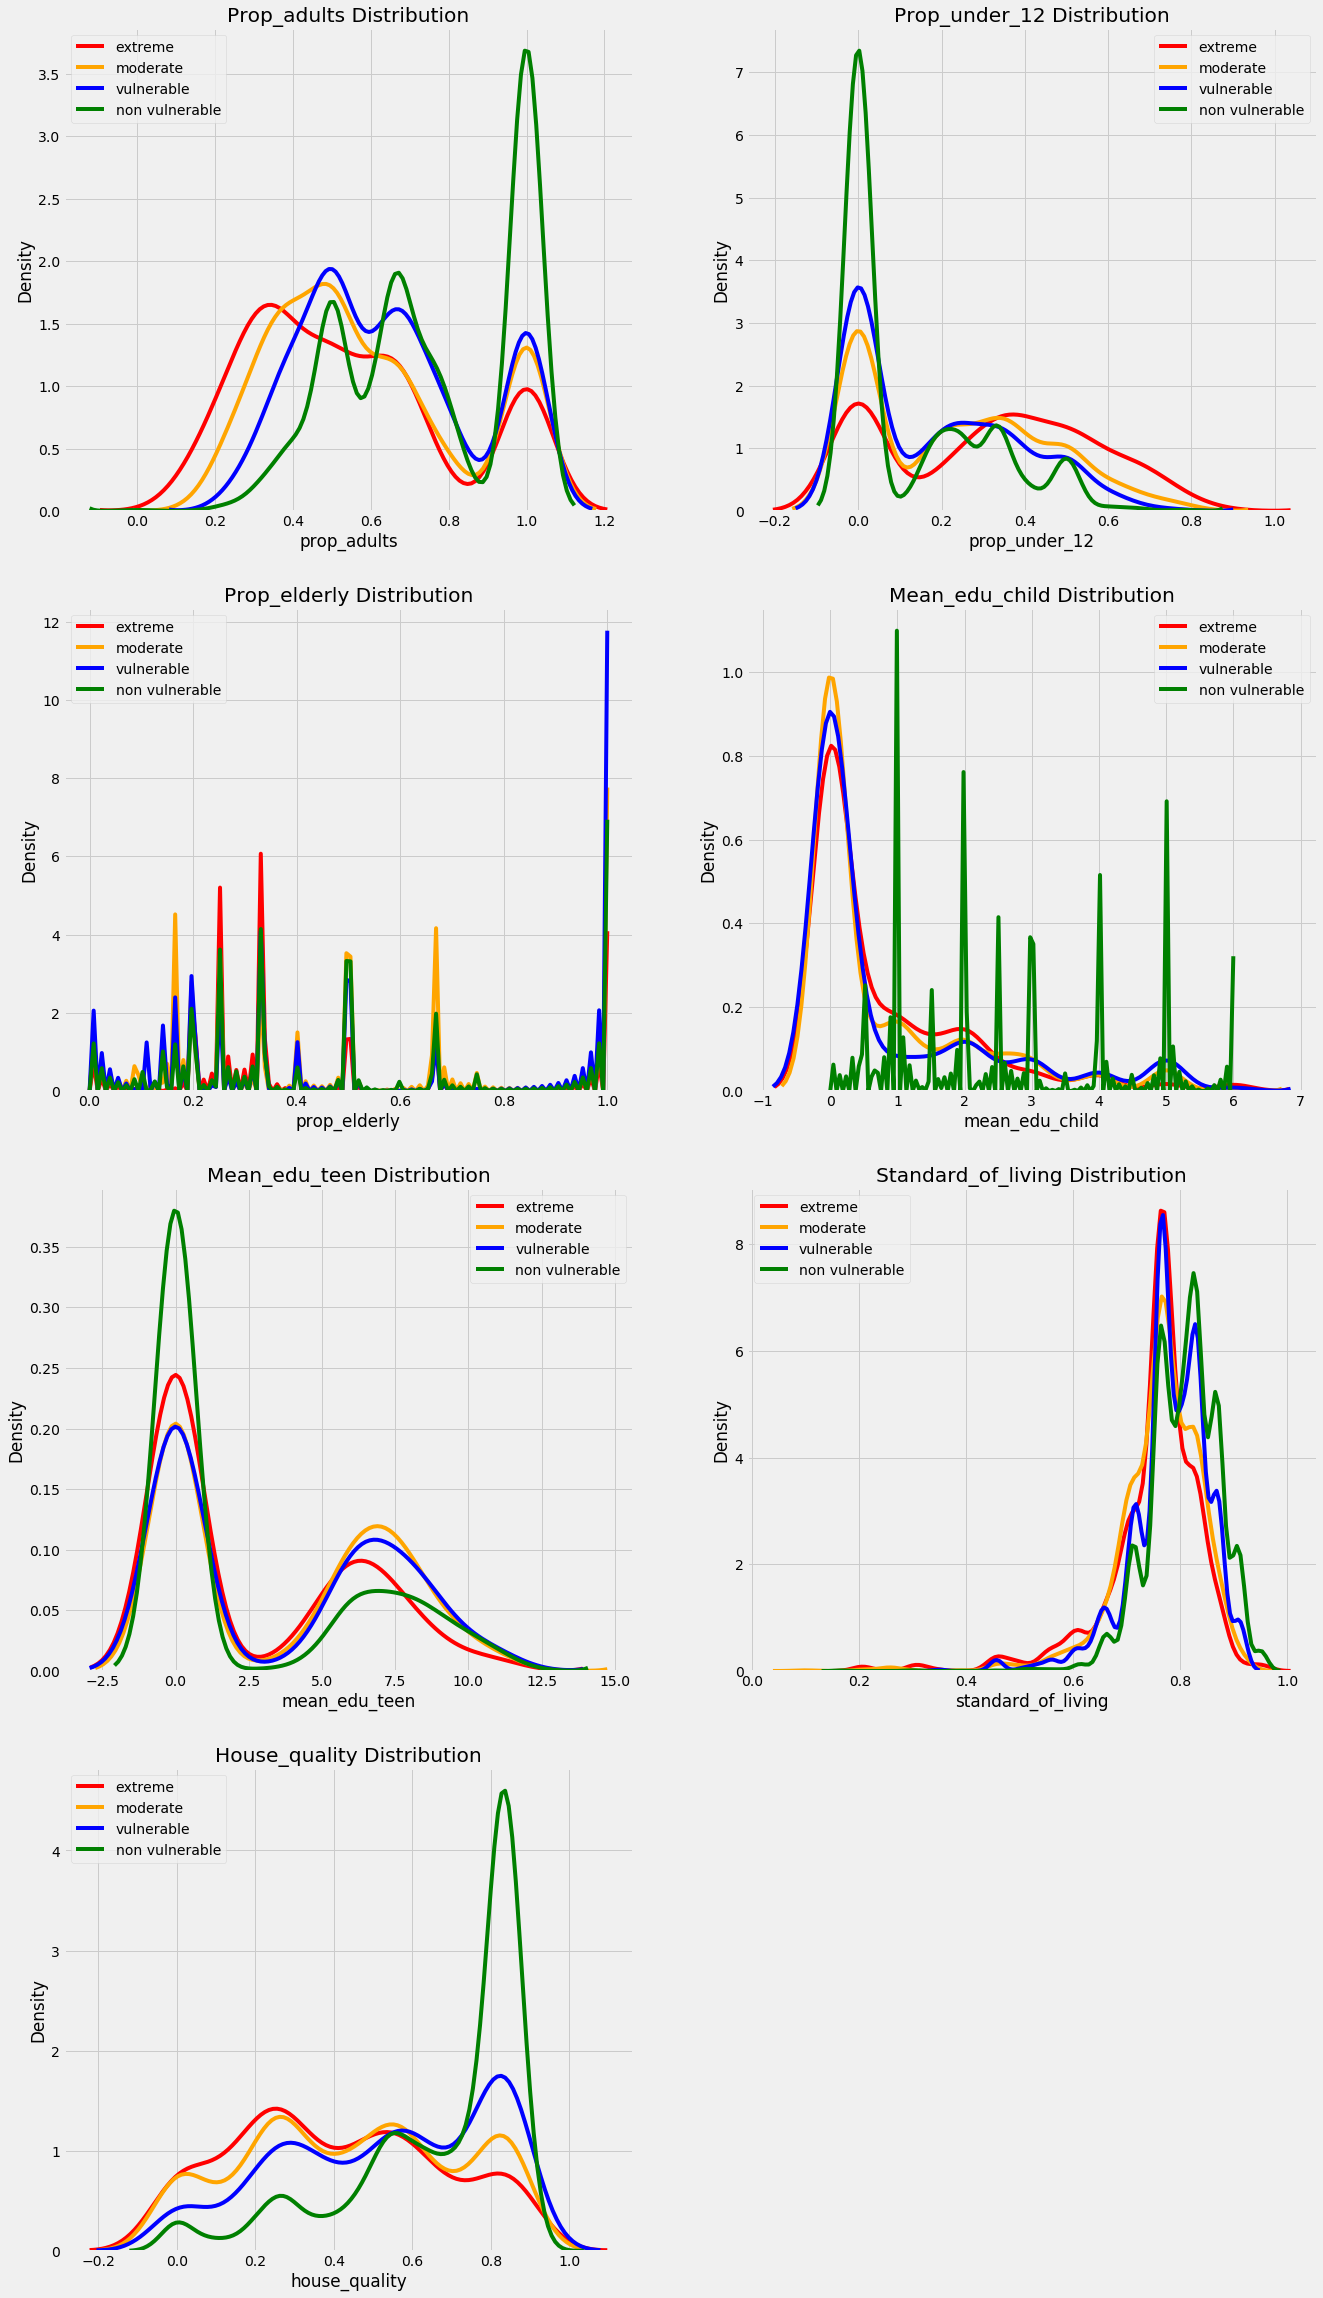

In [170]:
plot_distribution_cat(train,cont_variables)

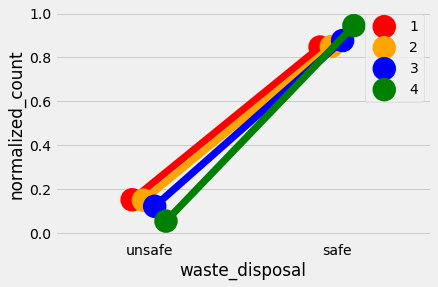

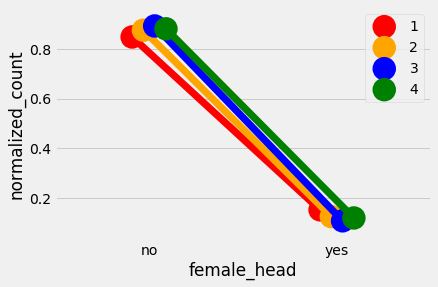

In [172]:
plot_categorical('safe_waste_disposal','waste_disposal',['unsafe','safe'],kind='point')
plot_categorical('female_head','female_head',['no','yes'],kind='point')

#### let's check the correlation of the engineered features with the Target variable

In [184]:
new_features = ['age_of_head','female_head','edu_head','prop_under_12','prop_adults','prop_elderly','mean_edu_child','mean_edu_teen','standard_of_living','house_quality','safe_waste_disposal']
results = calc_sp_pr(new_features)
results

,spearman_r,S_p_value,pearson_r,P_p_value
house_quality,0.371821,0.000000e+00,0.376941,2.931786e-320
edu_head,0.343274,2.072640e-262,0.329019,5.591787e-240
prop_adults,0.324818,1.355864e-233,0.322644,2.492253e-230
standard_of_living,0.268493,1.965304e-157,0.278821,4.009249e-170
safe_waste_disposal,0.149225,1.061062e-48,0.143245,5.630112e-45
age_of_head,0.083386,3.248476e-16,0.074152,3.957894e-13
prop_elderly,-0.007357,4.721243e-01,0.003622,7.233274e-01
female_head,-0.015295,1.349367e-01,-0.020734,4.270076e-02
mean_edu_teen,-0.111717,6.453347e-28,-0.089600,1.717236e-18
mean_edu_child,-0.174565,3.012739e-66,-0.080717,2.755919e-15


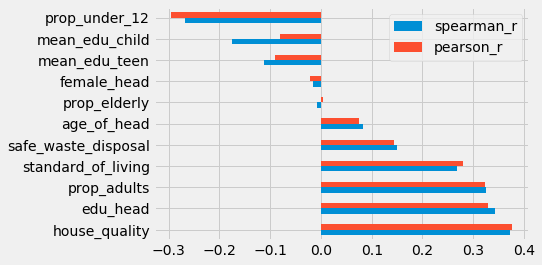

In [186]:
results[['spearman_r','pearson_r']].plot.barh()

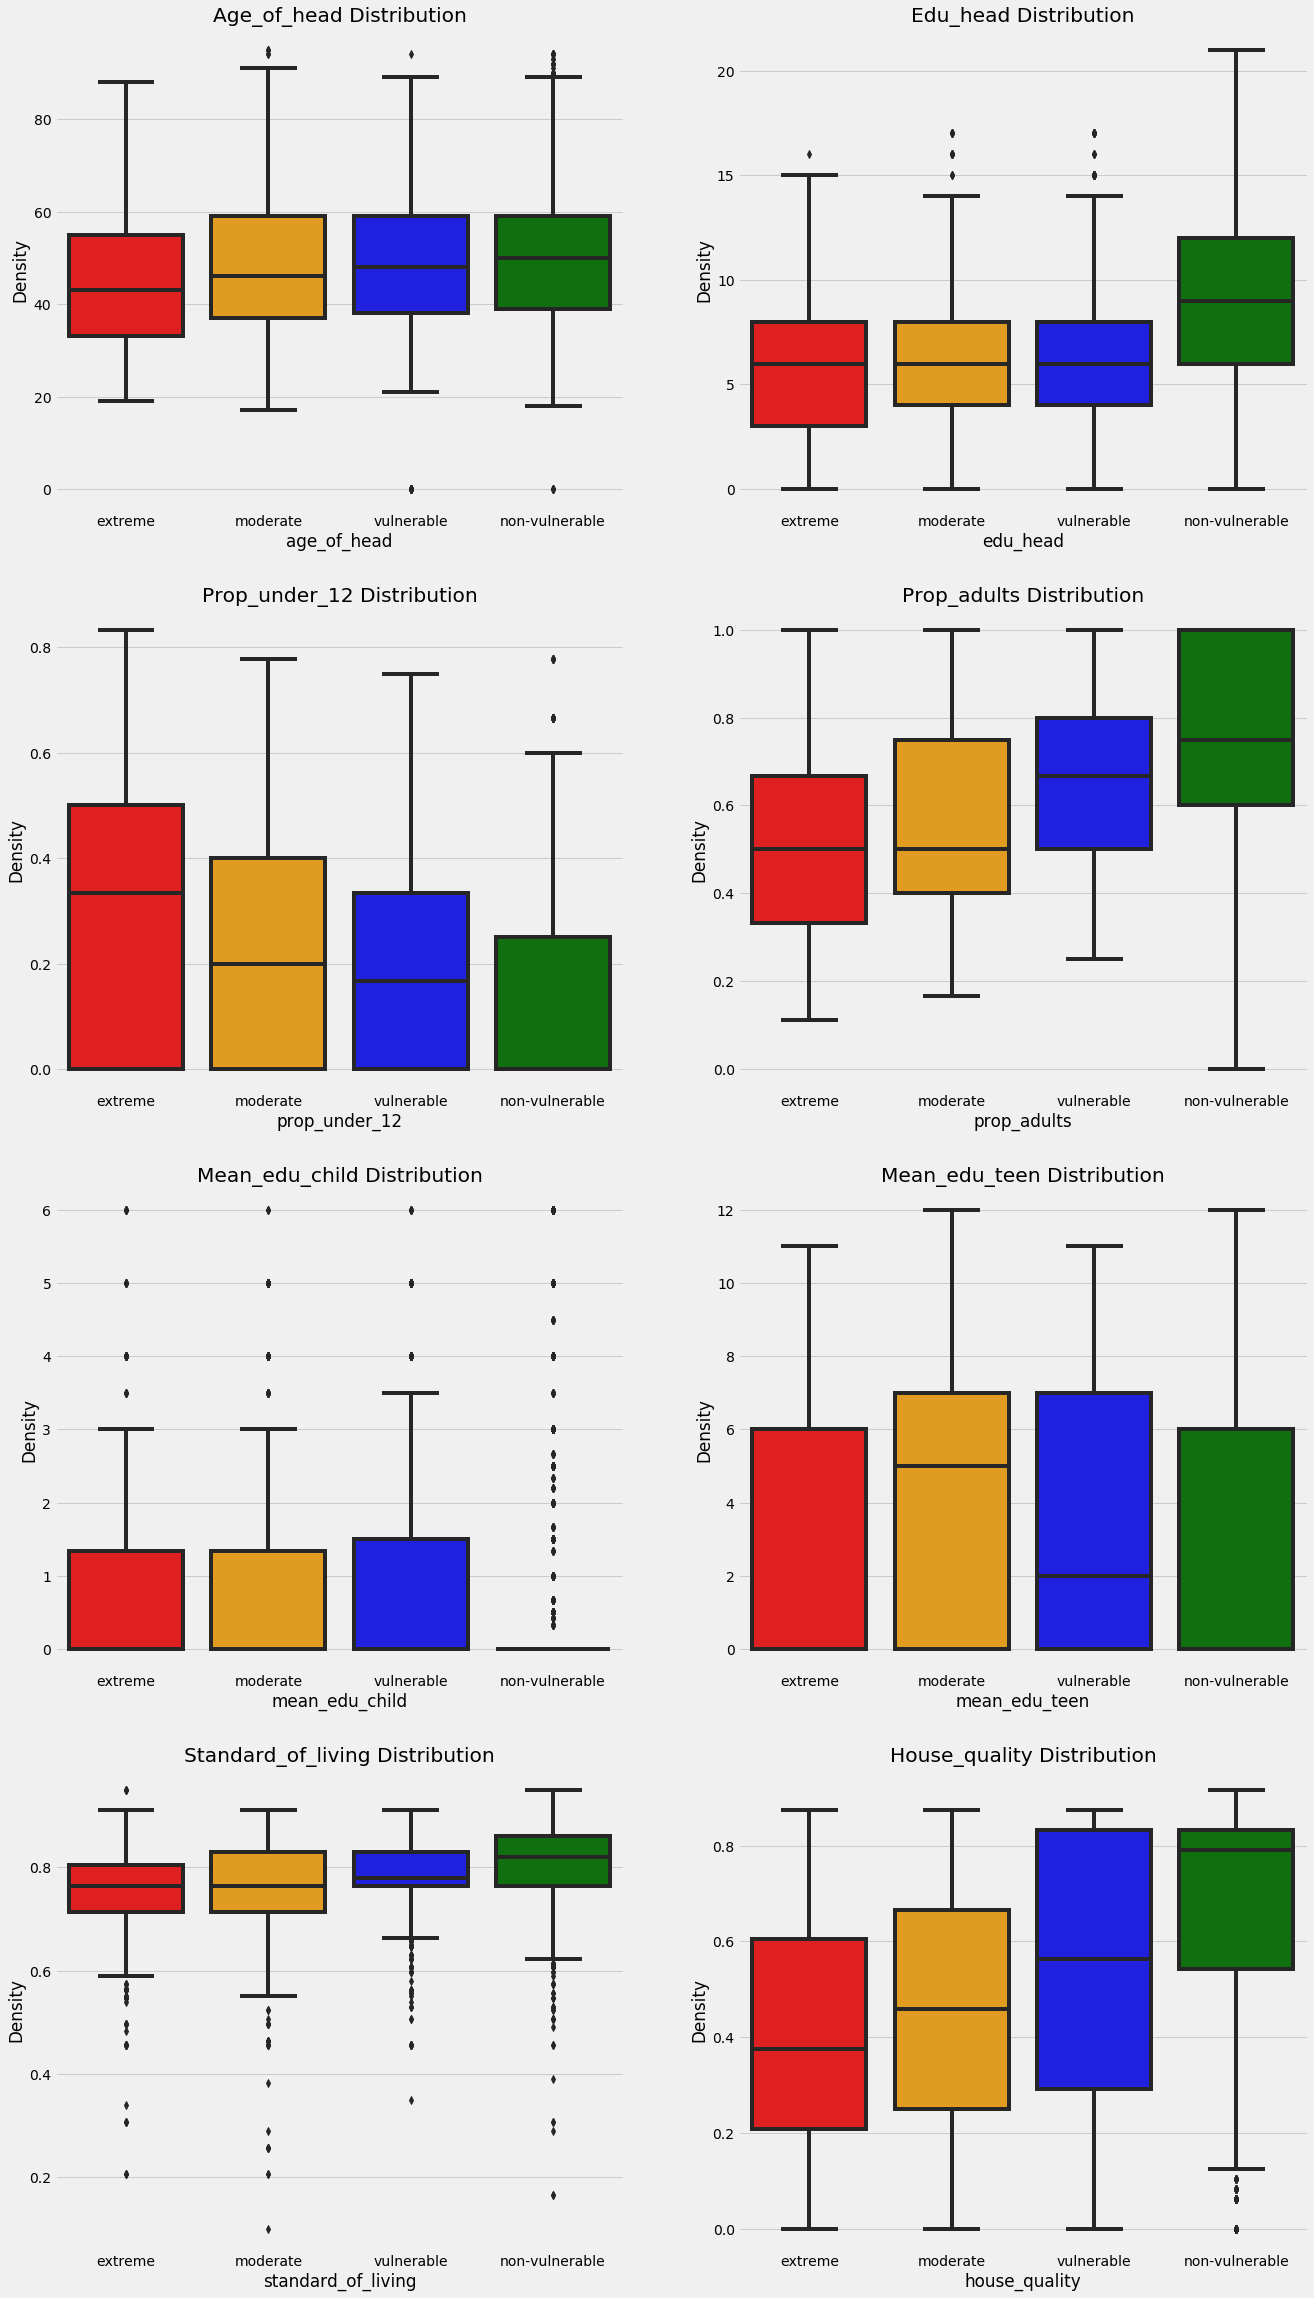

In [207]:
col_list = ['age_of_head','edu_head','prop_under_12','prop_adults','mean_edu_child','mean_edu_teen','standard_of_living','house_quality']
boxplot_distribution(col_list)

In [235]:
train.to_csv('training_set.csv')

In [236]:
train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,cielorazo,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,bedrooms,overcrowding,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,age,Target,dependency,rent-missing,wall_attrib,floor_attrib,roof_attrib,water_attrib,electric_attrib,sanitary_attrib,energy_attrib,wall_qual,roof_qual,floor_qual,edu_level,ownership_status,area,age_of_head,female_head,edu_head,prop_under_12,prop_adults,prop_elderly,mean_edu_child,mean_edu_teen,standard_of_living,house_quality,safe_waste_disposal
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,1,1,0,0,0,0,1,1,1,10,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,10.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,43,4,0.0,0,6,5,4,2,3,3,2,1,0,0,3,2,1,43,0,10,0.00,1.0,0.0,0.0,0.0,0.713333,0.375000,1
ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,12,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,12.0,1,1.000000,0,0,1,1,1,0,0,0,0,0,67,4,0.0,0,3,3,3,2,3,3,3,1,1,1,7,2,1,67,0,12,0.00,1.0,1.0,0.0,0.0,0.820000,0.437500,1
ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,11,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,11.0,2,0.500000,0,0,0,0,1,0,0,0,0,0,92,4,0.0,0,3,5,3,2,3,3,3,1,2,2,4,4,1,92,1,11,0.00,1.0,1.0,0.0,0.0,0.740000,0.645833,1
ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,9,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,17,4,1.0,0,6,5,3,2,3,3,3,2,2,2,3,2,1,38,0,11,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1
ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,11,4,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,11.0,3,1.333333,0,0,1,3,1,0,0,0,0,0,37,4,1.0,0,6,5,3,2,3,3,3,2,2,2,4,2,1,38,0,11,0.25,0.5,0.0,2.0,9.0,0.820000,0.833333,1


## we need to prepare our testing set as well having the same features and ordinal columns as our training set

In [6]:
test = pd.read_csv('test_set.csv',index_col='Id')
test.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamviv,escolari,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,dependency,techowaste,elecother,rent-missing
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ID_2f6873615,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,1,0,0,0,0,0,0,0,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,4,0.5,0,0,0
ID_1c78846d2,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,16,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,0,0,0,0,0,0,0,1,0,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0.5,0,0,0
ID_e5442cf6a,0.0,0,5,0,1,1,0,0.0,1,1,2,0,1,1,1,2,3,3,17,3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,72958b30c,1,2,0,3,16.500000,0,0,0,0,0,0,0,0,1,2,1.5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,41,0.5,0,0,0
ID_a8db26a79,0.0,0,14,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,16,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5b598fbc9,0,1,0,1,16.000000,0,0,0,0,0,0,0,1,0,1,1.0,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,1,0,59,0.0,0,0,0
ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,11,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,9.158261,0,0,0,0,1,0,0,0,0,2,0.5,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,0.0,0,0,0


In [7]:
ordinal_attributes = {'wall_attrib' :['paredother','pareddes','paredfibras','paredmad','paredzinc','paredzocalo','paredblolad','paredpreb'],
                       'floor_attrib':['pisonotiene','pisoother','pisonatur','pisomadera','pisocemento','pisomoscer'],
                       'roof_attrib' :['techootro','techowaste','techocane','techozinc','techoentrepiso'],
                       'water_attrib':['abastaguano','abastaguafuera','abastaguadentro'],
                       'electric_attrib' : ['noelec','elecother','coopele','public','planpri'],
                       'sanitary_attrib' : ['sanitario1','sanitario6','sanitario5','sanitario2','sanitario3'],
                       'energy_attrib' : ['energcocinar1','energcocinar4','energcocinar3','energcocinar2'],
                       'wall_qual' : ['epared1','epared2','epared3'],
                       'roof_qual' : ['etecho1','etecho2','etecho3'],
                       'floor_qual' : ['eviv1','eviv2','eviv3'],
                       'edu_level' : ['instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9'],
                       'ownership_status' : ['tipovivi5','tipovivi4','tipovivi3','tipovivi2','tipovivi1'],
                       'area':['area2','area1']
                  }

In [8]:
create_ordinal_columns(test,ordinal_attributes)

created ordinal column wall_attrib
created ordinal column floor_attrib
created ordinal column roof_attrib
created ordinal column water_attrib
created ordinal column electric_attrib
created ordinal column sanitary_attrib
created ordinal column energy_attrib
created ordinal column wall_qual
created ordinal column roof_qual
created ordinal column floor_qual
created ordinal column edu_level
created ordinal column ownership_status
created ordinal column area


In [9]:
for col_list in ordinal_attributes.values():
    test.drop(col_list,axis=1,inplace=True)

## mirroring the engineered features in the test set

In [10]:
#age of head
idx_head = test[['idhogar','age']][test.parentesco1 == 1]
test['age_of_head'] = 0
for row in idx_head.itertuples():
    test['age_of_head'][test.idhogar == row.idhogar] = row.age

In [11]:
#if household head is female
test['female_head'] = 0
test['female_head'][(test.parentesco1 == 1) & (test.female == 1)] = 1

In [12]:
#education of head of household
idx_edu_head = test[['idhogar','escolari']][test.parentesco1 == 1]
test['edu_head'] = 0
for row in idx_edu_head.itertuples():
    test['edu_head'][test.idhogar == row.idhogar] = row.escolari

In [13]:
## proportion of children under 12
test['prop_under_12'] = test['r4t1']/test['hogar_total']

In [14]:
#proportion of adults
test['prop_adults'] = test['hogar_adul']/test['hogar_total']

In [15]:
#proportion of elderly
test['prop_elderly'] = test['hogar_mayor']/test['hogar_total']

In [16]:
#education of children 0-12
idx_edu_chld = test[test.age <= 12].groupby('idhogar')['escolari'].mean()
idx_edu_chld = idx_edu_chld.reset_index()
test['mean_edu_child'] = 0.0
for row in idx_edu_chld.itertuples():
    test['mean_edu_child'][test.idhogar == row.idhogar] = row.escolari

In [17]:
#education of children 12-18
idx_edu_chld = test[(test.age >= 12) & (test.age <= 18)].groupby('idhogar')['escolari'].mean()
idx_edu_chld = idx_edu_chld.reset_index()
test['mean_edu_teen'] = 0.0
for row in idx_edu_chld.itertuples():
    test['mean_edu_teen'][test.idhogar == row.idhogar] = row.escolari

In [18]:
#standard of living score
test['standard_of_living'] = 1/5 * (1/4 * test['electric_attrib'] + 1/2 * test['water_attrib'] + 1/3 * test['energy_attrib'] + 1/4 * test['sanitary_attrib']\
+ 1/5 * (test['refrig'] + test['television'] + test['v18q'] + test['mobilephone'] + test['computer']))

In [19]:
#house quality score
test['house_quality'] = 1/4 * ((1/2 * test['wall_qual']) * (1/6 * test['wall_attrib']) + (1/2 * test['floor_qual']) * (1/6 * test['floor_attrib']) + (1/2 * test['roof_qual']) * (1/6 * test['roof_attrib']) + test['cielorazo'])

In [20]:
#safe waste disposal
test['safe_waste_disposal'] = 0
test['safe_waste_disposal'][(test.elimbasu1 == 1) | (test.elimbasu2 == 1)] = 1

In [21]:
test.to_csv('testing_set.csv')